# Laboratorium 2

### Przypomnienie implementacji algorytmu Strassena

In [1]:
using LinearAlgebra, DataFrames, BenchmarkTools, GFlops, Statistics, Plots

In [2]:
function divide_matrix(M, n)
    """
    :return: Four pieces of Matrix M (divided in half)
    This is an auxiliary function for strassen
    """
    m = div(n, 2)
    A11 = M[1:m, 1:m]
    A12 = M[1:m, m+1:n]
    A21 = M[m+1:n, 1:m]
    A22 = M[m+1:n, m+1:n]

    return A11, A12, A21, A22
end

divide_matrix (generic function with 1 method)

In [3]:
function strassen(A, B)
    """
    :return: C = A * B where A, B, C are matrices
    We can assume that dimensions of A and B are 2 ^ p.
    """
    
    n = size(A, 1)

    if n == 1
        
        if typeof(A) == Vector{Float64} && typeof(B) == Vector{Float64}
            return A .* B
        end
        
        return A * B
    end

    A11, A12, A21, A22 = divide_matrix(A, n)
    B11, B12, B21, B22 = divide_matrix(B, n)

    
    P1 = strassen(A11 + A22, B11 + B22)
    P2 = strassen(A21 + A22, B11)
    P3 = strassen(A11, B12 - B22)
    P4 = strassen(A22, B21 - B11)
    P5 = strassen(A11 + A12, B22)
    P6 = strassen(A21 - A11, B11 + B12)
    P7 = strassen(A12 - A22, B21 + B22)

    C11 = P1 + P4 - P5 + P7
    C12 = P3 + P5
    C21 = P2 + P4
    C22 = P1 - P2 + P3 + P6

    return vcat(hcat(C11, C12), hcat(C21, C22))
end

strassen (generic function with 1 method)

## Rekurencyjne odwracanie macierz


### Opis algorytmu
Algorytm przyjmuję na wejściu macierz. Jego zadaniem jest znaleźć macierz odwrotną do zadanej. Robi to metodą rekurencyjną, zgodnie z wzorami:

#### Macierz A

\begin{bmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{bmatrix}


#### Inwersja macierzy A

\begin{bmatrix}
A_{11}^{-1} \left( I + A_{12} S_{22}^{-1} A_{21} A_{11}^{-1} \right) & -A_{11}^{-1} A_{12} S_{22}^{-1} \\
-S_{22}^{-1} A_{21} A_{11}^{-1} & S_{22}^{-1}
\end{bmatrix} 

### Pseudokod
Gdy macierzy nie da się już podzielić (macierz 1x1) wówczas jej inwersja liczona jest przy pomocy wzoru: $A^{-1} = \frac{1}{A}$


### Implementacja

In [4]:
struct NonSquareMatrixError <: Exception
    message::String
end

function matrix_inverse(A)
    """
    :return matrix B, such that A * B = I
    """
    
    n = size(A, 1)
    m = size(A, 2)
    
    if n != m 
        throw(NonSquareMatrixError("Matrix is not the square"))
    end
        
    if n == 1
        return [1 / A[1, 1]]
    end
    
        
    m = div(n, 2)
    A11, A12, A21, A22 = divide_matrix(A, n)
    
    A11_inversed = matrix_inverse(A11)
    S22 = A22 - strassen(strassen(A21, A11_inversed), A12)
    S22_inversed = matrix_inverse(S22)
    
    
    
    B = zeros(n, n)
    eye = Matrix{Float64}(I, div(n, 2) , div(n, 2))
    
    B[1:m, 1:m] = strassen(A11_inversed, eye + strassen(strassen(strassen(A12, S22_inversed), A21), A11_inversed))
    B[1:m, m+1:n] = strassen(strassen(-A11_inversed, A12), S22_inversed)
    B[m+1:n, 1:m] = strassen(strassen(-S22_inversed, A21), A11_inversed)
    B[m+1:n, m+1:n] = S22_inversed
    
    return B
    
end

matrix_inverse (generic function with 1 method)

In [ ]:
# To check corectness
# This implementation may be unstable
eps = 10 ^ -4
min_value = 0.00000001
max_value = 1
for j in 1:3
    for i in 1:8
        A = min_value .+ (max_value - min_value) * rand(2 ^ i, 2 ^ i)
        
        C = matrix_inverse(A)
        
        B = matrix_inverse(C)

        if isapprox(A, B, atol=eps) == false
            println("FALSE!!!", size(A, 1))
            
        end
    end
end

### Pomiary

In [10]:
min_value = 0.00000001
max_value = 1
inversion_times = DataFrame(size = [], flops= [], time = [])

for i in 1: 5
    for size in 1: 6
        A = min_value .+ (max_value - min_value) * rand(2 ^ size, 2 ^ size)
        m_time = @elapsed matrix_inverse(A)
        m_flops = @count_ops matrix_inverse($A)
        push!(inversion_times, [2^size , m_flops, m_time])
    end
end     

In [11]:
for i in 1:nrow(inversion_times)
    inversion_times[i, :flops] = inversion_times[i, :flops].add64 + inversion_times[i, :flops].sub64 + inversion_times[i, :flops].div64 + inversion_times[i, :flops].neg64 + inversion_times[i, :flops].mul64
end
display(inversion_times)

,size,flops,time
,Any,Any,Any
1,2,6,2.59e-5
2,4,208,4.39e-5
3,8,2460,0.0003038
4,16,21916,0.0021021
5,32,173556,0.0145889
6,64,1298188,0.164424
7,2,6,1.56e-5
8,4,208,4.55e-5
9,8,2460,0.0003631


In [12]:
inversion_time_group = groupby(inversion_times, [:size])
inversion_time_statistics = combine(inversion_time_group, "time" => mean, "flops" => mean, "time" => std, "flops" => std)

,size,time_mean,flops_mean,time_std,flops_std
,Any,Float64,Float64,Float64,Float64
1,2,1.868e-5,6.0,4.11242e-6,0.0
2,4,4.338e-5,208.0,2.42012e-6,0.0
3,8,0.00033694,2460.0,3.57914e-5,0.0
4,16,0.0023722,21916.0,0.000235103,0.0
5,32,0.0158621,173556.0,0.00158701,0.0
6,64,0.15252,1.29819e6,0.0111447,0.0


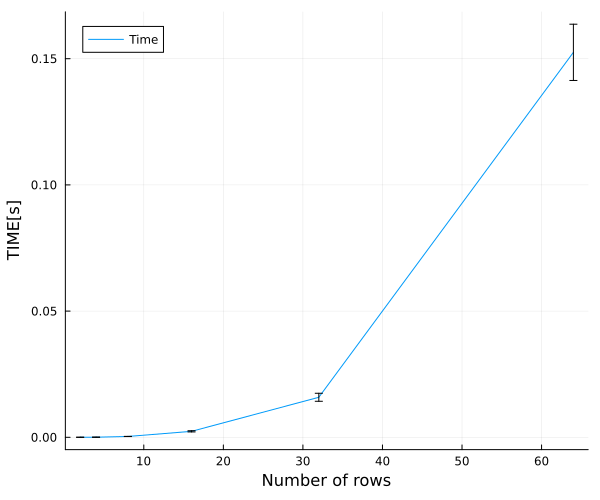

In [13]:
plot(inversion_time_statistics.size, inversion_time_statistics.time_mean, 
    size = (600, 500), yerr=inversion_time_statistics.time_std,
    yaxis = "TIME[s]", xaxis = "Number of rows", label="Time")

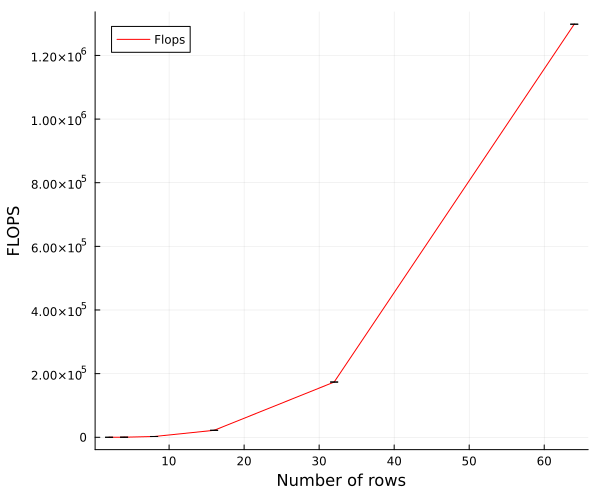

In [14]:
plot(inversion_time_statistics.size, inversion_time_statistics.flops_mean, 
    size = (600, 500), color="red",yerr=inversion_time_statistics.flops_std,
    yaxis = "FLOPS", xaxis = "Number of rows", label="Flops")

### Złożoność obliczeniowa
Nasza implementacja odwracania macierzy, do mnożenia macierzy używa algorytmu Strassena, którego złożoność wynosi: O(n$^{\log_2(7)}$). Złożoność obliczeniowa algorytmu to rozwiązanie równania: <br>
<center>
$O(n) = 2 \cdot O\left(\frac{n}{2}\right) + 10 \cdot O({n}^{\log_2(7)}) + d$
</center>
gdzie n to liczba elementów w jednym wierszu macierzy. <br>

Na podstawie [Master Theorem](https://en.wikipedia.org/wiki/Master_theorem_(analysis_of_algorithms)) złożoność obliczeniowa tego  algorytmu wynosi $O({n}^{\log_2(7)})$




### Porównanie z MATLABem

Kod w Matlab
```Matlab
A = [0.5488, 0.5929; 
    0.7094, 0.0734];

A_inv = inv(A);
fprintf("A");
disp(A_inv);

fprintf("A2");
A2 = [0.2722, 0.1980, 0.1500, 0.4826;
    0.6070, 0.3818, 0.2489, 0.6313;
    0.1088, 0.9294, 0.1723, 0.5508;
    0.3195, 0.5077, 0.3096, 0.9883];
disp(A2);
```

#### Wyniki
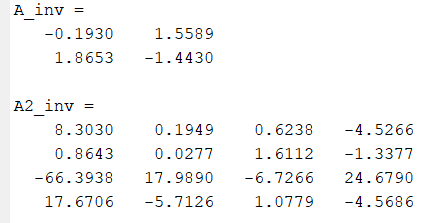

In [ ]:
A = [0.5488 0.5929; 
    0.7094 0.0734];

A2 = [0.2722 0.1980 0.1500 0.4826;
    0.6070 0.3818 0.2489 0.6313;
    0.1088 0.9294 0.1723 0.5508;
    0.3195 0.5077 0.3096 0.9883];

display(matrix_inverse(A))
display(matrix_inverse(A2))


Otrzymane macierze zgadzają się z tymi obliczonymi przy użyciu funkcji inv() w Matlabie

## Rekurencyjna LU faktoryzacja

### Opis algorytmu
Algorytm przyjmuję na wejściu macierz. Jego zadaniem jest znaleźć macierze L i U, takie że L jest trójkątna dolna, U jest trójkątna górna oraz L* U = A. Robi to metodą rekurencyjną, zgodnie z wzorami:

#### Macierz A
\begin{bmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{bmatrix}


#### Faktoryzacja L U macierzy A
* Macierz L:

\begin{bmatrix}
L_{11} &  0\\
A_{21} * U_{11}^{-1} & S_{L}
\end{bmatrix}
* Macierz U:

\begin{bmatrix}
U_{11} & L_{11}^{-1} * A_{12}\\
0 & S_{U}
\end{bmatrix}

Gdzie: 
* S - dopełnienie Schura (A_{22} - U_{11}^{-1} & S_{L} * L_{11}^{-1} * A_{12})
* S_L, S_U - są to macierze obliczone przez rekurencyjne odwołanie do faktoryzacji macierzy S
* L_{11}, U_{11} - powstały przez LU faktoryzacje A_{11}

### Pseudokod

```
if size(A) == 2x2
    L = [A[1,1], 0 ; A[2,1], A[2,2] - A[2,1] * A[1,2] / A[1,1]]
    U = [1, A[1,2]/A[1,1]; 0, 1]
else
    \\ działaj według powyrzszych wzorów
```


### Implementacja

In [15]:
function _matrix_LU_factor(A, n)
    if n == 2
        a22 = A[2,2] - A[2,1] * A[1,2] / A[1,1]
        return LowerTriangular([A[1,1] 0; A[2,1] a22]),  UnitUpperTriangular([1 A[1,2]/A[1,1]; 0 1])
    end
    """
    Helping function to matrix_LU_factor() func
    """
    m = div(n, 2)

    A11, A12, A21, A22 = divide_matrix(A, n)
    L11, U11 = _matrix_LU_factor(A11, m)

    U12 = strassen(matrix_inverse(L11),A12)
    L21 = strassen(A21,matrix_inverse(U11))

    S = A22 - strassen(L21, U12)

    L22, U22 = _matrix_LU_factor(S, m)

    L = vcat(hcat(L11, zeros(m,m)), hcat(L21, L22))
    U = vcat(hcat(U11, U12), hcat(zeros(m,m), U22))
    return LowerTriangular(L), UnitUpperTriangular(U)
end


function matrix_LU_factor(A)
    """
    :return matrixes L, U : L * U = A and L is upper triangular matrix and U is lower triangular matrix
    A must be in shape (2^i, 2^i) where i is Natural
    """
    
    n = size(A, 1)
    m = size(A, 2)
    
    if n != m 
        throw(NonSquareMatrixError("Matrix is not the square"))
    end
    log2_n = log2(n)
    if !(trunc(Int, log2_n) - log2_n ≈ 0)
        throw(ArgumentError("A, not in (2^i, 2^i) shape, shape= $(size(A))"))
    end

    return _matrix_LU_factor(A, n)
end

matrix_LU_factor (generic function with 1 method)

In [16]:
# To check corectness
# This implementation may be unstable
eps = 10 ^ -5
min_value = 0.00000001
max_value = 1
for j in 1:2
    for i in 1:8
        A = min_value .+ (max_value - min_value) * rand(2 ^ i, 2 ^ i)
        
        L, U = matrix_LU_factor(A)
        
        B = L * U

        if isapprox(A, B, atol=eps) == false
            println("FALSE!!!", size(A, 1))
            
        end
    end
end

FALSE!!!128


### Pomiary

In [17]:
min_value = 0.00000001
max_value = 1
LU_times = DataFrame(size = [], flops= [], time = [])

for i in 1: 5
    for size in 1: 6
        A = min_value .+ (max_value - min_value) * rand(2 ^ size, 2 ^ size)
        m_time = @elapsed matrix_LU_factor(A)
        m_flops = @count_ops matrix_LU_factor($A)
        push!(LU_times, [2^size, m_flops, m_time])
    end
end     

In [18]:
for i in 1:nrow(LU_times)
    LU_times[i, :flops] = LU_times[i, :flops].add64 + LU_times[i, :flops].sub64 + LU_times[i, :flops].div64 + LU_times[i, :flops].neg64 + LU_times[i, :flops].mul64
end
display(LU_times)

,size,flops,time
,Any,Any,Any
1,2,22,7.0e-6
2,4,96,4.68e-5
3,8,1200,0.0002004
4,16,12388,0.0014866
5,32,107456,0.0099139
6,64,847124,0.134321
7,2,22,5.7e-6
8,4,96,4.71e-5
9,8,1200,0.000206


In [19]:
LU_time_group = groupby(LU_times, [:size])
LU_time_statistics = combine(LU_time_group, "time" => mean, "flops" => mean, "time" => std, "flops" => std)

,size,time_mean,flops_mean,time_std,flops_std
,Any,Float64,Float64,Float64,Float64
1,2,5.68e-6,22.0,7.79102e-7,0.0
2,4,4.252e-5,96.0,4.46844e-6,0.0
3,8,0.00019582,1200.0,1.67721e-5,0.0
4,16,0.00154236,12388.0,0.000113028,0.0
5,32,0.0106174,107456.0,0.00101309,0.0
6,64,0.100947,847124.0,0.0202273,0.0


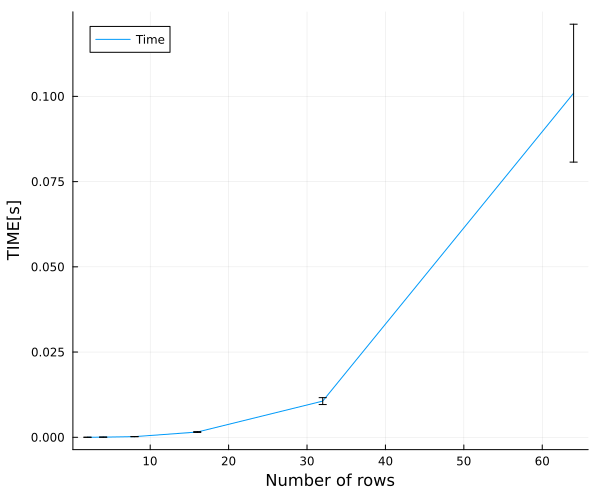

In [20]:
plot(LU_time_statistics.size, LU_time_statistics.time_mean, 
    size = (600, 500), yerr=LU_time_statistics.time_std,
    yaxis = "TIME[s]", xaxis = "Number of rows", label="Time")

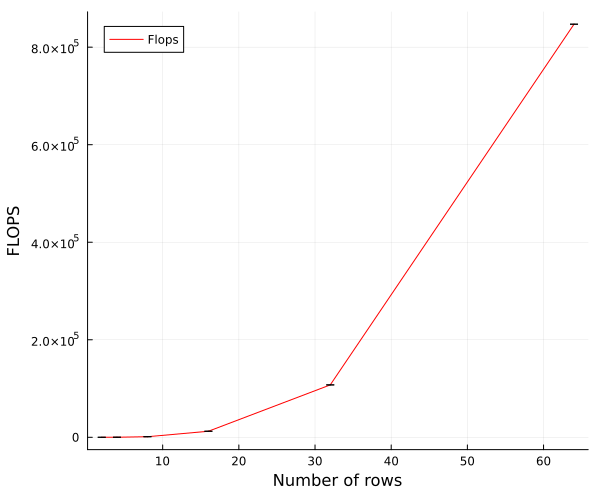

In [21]:
plot(LU_time_statistics.size, LU_time_statistics.flops_mean, 
    size = (600, 500), color="red",yerr=LU_time_statistics.flops_std,
    yaxis = "FLOPS", xaxis = "Number of rows", label="Flops")

### Złożoność obliczeniowa
Podobnie jak w przypadku odwracania macierzy mamy do czynienia z złorzonością obliczeniową $O({n}^{\log_2(7)})$


### Porównanie z MATLABem

Kod w Matlab
```Matlab
A = [0.5488, 0.5929; 
    0.7094, 0.0734];
    
[L,U] = lu(A)

fprintf('Macierz L:\n');
disp(L);

fprintf('Macierz U:\n');
disp(U);

fprintf('Macierz L * U:\n');
disp(L * U);
```

#### Wyniki
```
Macierz L:
   0.7736   1.0000
   1.0000        0
Macierz U:
   0.7094   0.0734
        0   0.5361
Macierz L * U:
   0.548800   0.592900
   0.709400   0.073400
```

In [ ]:
A = [0.5488 0.5929; 
    0.7094 0.0734]

L_U = matrix_LU_factor(A)
display(L_U[1])
display(L_U[2])
display(prod(L_U))

display(lu(A))

Otrzymane przez nas macierze nie są takie same poniewrz w Matlabie faktoryzacja LU zwraca L jako **przepermutowaną** macierz trujkątną dolną z jedynkami na przekątnej. Pomimo tego iloczyn macierzy L, U, wyliczonych naszą implementacją faktoryzacji oraz ta wyliczona przez wbudowaną funkcje w Madlab'e, jest równy macierzy A


#### Wnioski
trudno porównać wyniki naszego algorytmu i innych ze względu na ilość różnych reprezentacji macierzy LU. Np to w której macierzy są jedynki na przekątnej (o ile są równe jeden).

## Rekursywne obliczanie wyznacznika

### Opis algorytmu
Algorytm przyjmuję na wejściu macierz. Jego zadaniem jest obliczenie wyznacznika A. Robi to korzystając z rekurencyjnej metody znajdywania LU faktoryzacji:

* Macierz L

\begin{bmatrix}
l_{11} & 0 & \dots & 0\\
l_{21} & l_{22} & \dots & 0\\
\vdots & \vdots & \ddots & \vdots\\
l_{n1} & l_{n2} & \dots & l_{nn}
\end{bmatrix}

* Macierz U

\begin{bmatrix}
1 & u_{12} & \dots & u_{1n}\\
0 & 1 & \dots & u_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \dots & 1
\end{bmatrix}

#### Wyznacznik

det(A) = \[ \prod_{i=1}^{n} l_{ii} \]
​

### Pseudokod

```
return prod(l_{ii})
```


### Implementacja

In [22]:
function matrix_determinant(A)
    """
    :return determinant of matrix
    A must be in shape (2^i, 2^i) where i is Natural
    """
    
    L, U = matrix_LU_factor(A)

    diagonal = [L[i,i] for i in 1:size(A, 1)]
    return prod(diagonal)
end

matrix_determinant (generic function with 1 method)

In [ ]:
# To check corectness
# This implementation may be unstable
eps = 10 ^ -5
min_value = 0.00000001
max_value = 1
for j in 1:2
    for i in 1:8
        A = min_value .+ (max_value - min_value) * rand(2 ^ i, 2 ^ i)
        
        my_det_a = matrix_determinant(A)
        det_a = det(A)
    
        if isapprox(my_det_a, det_a, atol=eps) == false
            println("FALSE!!! my_det:$my_det_a, det(A):$det_a \n", size(A, 1))
            
        end
    end
end

### Pomiary

In [38]:
min_value = 0.00000001
max_value = 1
det_times = DataFrame(size = [], flops= [], time = [])

for i in 1: 5
    for size in 1: 6
        A = min_value .+ (max_value - min_value) * rand(2 ^ size, 2 ^ size)
        m_time = @elapsed matrix_LU_factor(A)
        m_flops = @count_ops matrix_LU_factor($A)
        push!(det_times, [2 ^ size, m_flops, m_time])
    end
end     

In [39]:
for i in 1:nrow(det_times)
    det_times[i, :flops] = det_times[i, :flops].add64 + det_times[i, :flops].sub64 + det_times[i, :flops].div64 + det_times[i, :flops].neg64 + det_times[i, :flops].mul64
end
display(det_times)

,size,flops,time
,Any,Any,Any
1,2,22,9.0e-6
2,4,96,5.19e-5
3,8,1200,0.0002063
4,16,12388,0.0016387
5,32,107456,0.0137173
6,64,847124,0.0973751
7,2,22,5.8e-6
8,4,96,4.27e-5
9,8,1200,0.000174


In [40]:
det_time_group = groupby(det_times, [:size])
det_time_statistics = combine(det_time_group, "time" => mean, "flops" => mean, "time" => std, "flops" => std)

,size,time_mean,flops_mean,time_std,flops_std
,Any,Float64,Float64,Float64,Float64
1,2,6.36e-6,22.0,1.49766e-6,0.0
2,4,4.402e-5,96.0,5.91583e-6,0.0
3,8,0.00019908,1200.0,2.02743e-5,0.0
4,16,0.0016091,12388.0,0.000143245,0.0
5,32,0.011738,107456.0,0.00150172,0.0
6,64,0.0928166,847124.0,0.00997413,0.0


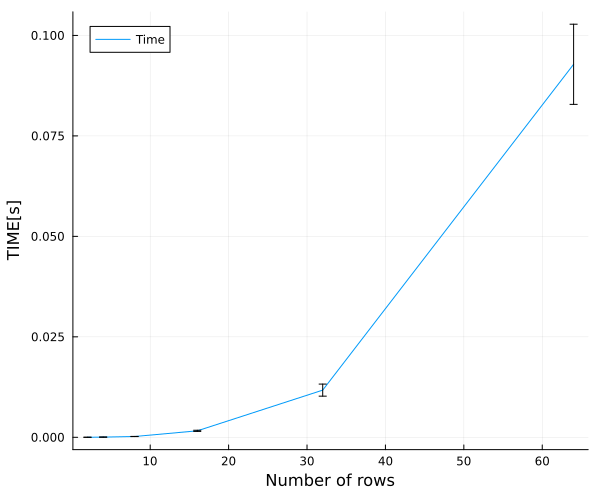

In [41]:
plot(det_time_statistics.size, det_time_statistics.time_mean, 
    size = (600, 500), yerr=det_time_statistics.time_std,
    yaxis = "TIME[s]", xaxis = "Number of rows", label="Time")

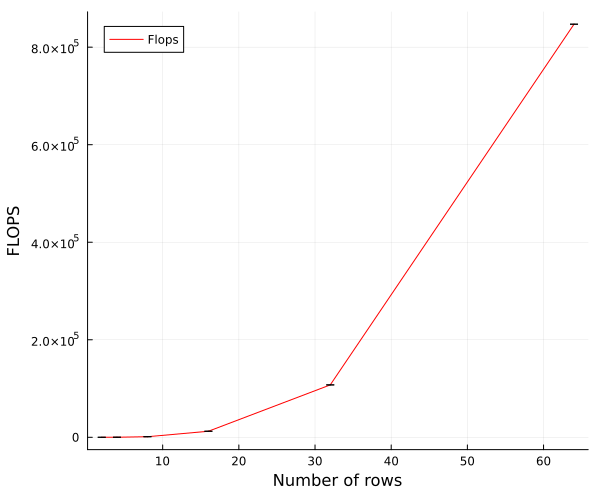

In [42]:
plot(det_time_statistics.size, det_time_statistics.flops_mean, 
    size = (600, 500), color="red",yerr=det_time_statistics.flops_std,
    yaxis = "FLOPS", xaxis = "Number of rows", label="Flops")

### Złożoność obliczeniowa

Złożoność obliczeniowa wyliczania wyznacznika ściśle zalerzy od złożoności urzytej metody LU faktoryzacji dlatego też złożoność tego algorytmu wynosi $O({n}^{\log_2(7)} + n) = $O({n}^{\log_2(7)})$$


### Porównanie z MATLABem

Kod w Matlab
```Matlab
A = [0.5488, 0.5929; 
    0.7094, 0.0734];
    
det_A = det(A)

fprintf('Wyznacznik A:\n');
disp(det_A);
```

#### Wyniki
```
det_A = -0.3803
Wyznacznik A:
-0.3803
```

In [ ]:
A = [0.5488 0.5929; 
    0.7094 0.0734]

det_A = matrix_determinant(A)
display(det_A)

# display(det(A))

Otrzymane przez nas wyniki zgadzają się z matlabem
